# Overview: Dominance of Political Betting

In [ ]:
import json
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import cumfreq
from scipy.stats import beta
from datetime import datetime
from sklearn.linear_model import LinearRegression

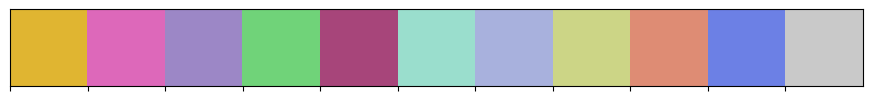

In [ ]:
special_color = "#F73A5A"
base_color = '#E0D4AE'
colors = ["#E0B531", "#DD68BA", "#9C87C6", "#70D379", "#A7457A", "#9ADECD", "#A8B1DD", "#CCD586", "#DE8C74", "#6C80E5", "#C9C9C9"]

sns.palplot(colors)

In [ ]:
# From Web retrieve
with open('./data/events_details.json', 'r', encoding='utf-8') as file: 
    data = json.load(file)

# From Gamma API
with open('./data/Categories.json', 'r', encoding='utf-8') as file: 
    data_categories = json.load(file)

## Event-Market Dynamics

In [ ]:
# Extract volume and market count for each event
event_volumes = []
market_counts = []

for event_url, event_details in data.items():
    event_data = event_details.get('props', {}).get('pageProps', {}).get('dehydratedState', {}).get('queries', [])
    if event_data and event_data[0].get('state', {}).get('data'):
        volume = event_data[0]['state']['data'].get('volume')
        markets = event_data[0]['state']['data'].get('markets', [])
        if volume is not None:
            event_volumes.append(volume)
            market_counts.append(len(markets))

# Convert to DataFrame
df_events = pd.DataFrame({'EventVolume': event_volumes, 'MarketCount': market_counts})

In [ ]:
category_map = {
    cat['id']: (
        'CoV' if cat['label'] == 'Coronavirus' else
        'Pop' if cat['label'] == 'Pop Culture' else
        cat['label']
    )
    for cat in data_categories
}

event_categories = []
for event_url, event_details in data.items():
    categories = event_details.get('props', {}).get('pageProps', {}).get('dehydratedState', {}).get('queries', [])[0].get('state', {}).get('data', {}).get('categories', [])
    if categories:
        category_id = categories[0].get('parentCategory') or categories[0].get('id')
        event_categories.append(category_map.get(category_id, 'Unknown'))
    else:
        event_categories.append('Unknown')

# Convert to DataFrame
df_events['Category'] = event_categories

# Percentage of events category
category_counts = df_events['Category'].value_counts(normalize=True)

# Total volume of Polymarket events
category_total_volumes = df_events.groupby('Category')['EventVolume'].sum()
total_volume = df_events['EventVolume'].sum()
category_volume_percentage = (category_total_volumes / total_volume)

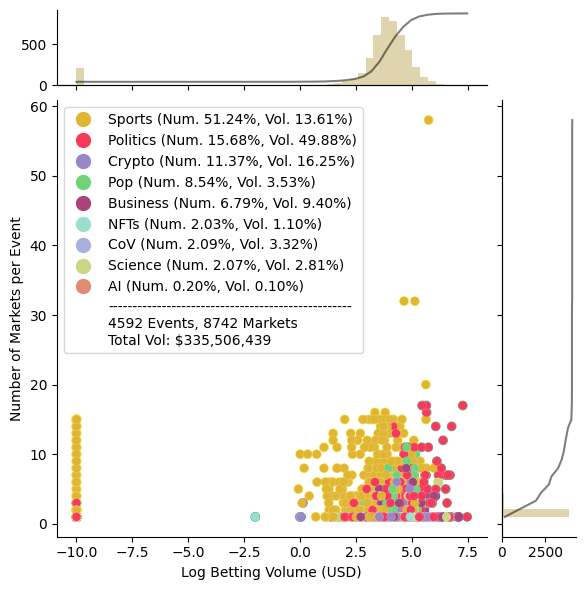

In [ ]:
x = np.log10(df_events['EventVolume'].replace(0, 1e-10))
y = df_events['MarketCount']

# Plot with joint distribution
g = sns.JointGrid(x=x, y=y)
g.ax_joint.scatter(x, y, c=pd.Categorical(df_events['Category']).codes, cmap='viridis')

n_bins = 50

# Plot Margins
values_x, _ = np.histogram(x, bins=n_bins)
g.ax_marg_x.hist(x, bins=n_bins, color=base_color)
max_count_x = max(values_x)

values_y, _ = np.histogram(y, bins=n_bins)
g.ax_marg_y.hist(y, bins=n_bins, orientation="horizontal", color=base_color)
max_count_y = max(values_y)

g.ax_marg_x.set_ylim(0, max_count_x * 1.1)
g.ax_marg_y.set_xlim(0, max_count_y * 1.1)

# Calculate and plot CDF of x axis

cumulative_x = np.cumsum(values_x)
ax_marg_x_cdf = g.ax_marg_x.twinx()
ax_marg_x_cdf.plot(np.linspace(x.min(), x.max(), n_bins), cumulative_x / cumulative_x[-1], c="black", alpha=0.5)
ax_marg_x_cdf.set_yticks([])
ax_marg_x_cdf.spines['top'].set_visible(False)
ax_marg_x_cdf.spines['right'].set_visible(False)

# Calculate and plot CDF of y axis
cumulative_y = np.cumsum(values_y)
ax_marg_y_cdf = g.ax_marg_y.twiny()
ax_marg_y_cdf.plot(cumulative_y / cumulative_y[-1], np.linspace(y.min(), y.max(), n_bins), c="black", alpha=0.5)
ax_marg_y_cdf.set_xticks([])
ax_marg_y_cdf.spines['top'].set_visible(False)
ax_marg_y_cdf.spines['right'].set_visible(False)

# Add the legend
category_unique = df_events['Category'].unique()
category_colors = {category: (special_color if category == 'Politics' else colors[i]) for i, category in enumerate(category_unique)} # Highlight Politics
legend_handles = [mlines.Line2D([], [], color=category_colors[category], marker='o', linestyle='None',
                                markersize=10, label=f"{category} (Num. {category_counts[category]:.2%}, Vol. {category_volume_percentage[category]:.2%})")
                  for category in category_unique]

legend_handles.append(mpatches.Patch(color='none', label=f"{'-'*50}\n{len(df_events)} Events, {sum(df_events['MarketCount'])} Markets\nTotal Vol: ${total_volume:,.0f}"))

g.ax_joint.scatter(x, y, c=[category_colors[cat] for cat in df_events['Category']], s=40, edgecolor='white', linewidth=0.1)


g.ax_joint.legend(handles=legend_handles, bbox_to_anchor=(0, 1), loc='upper left')

g.set_axis_labels('Log Betting Volume (USD)', 'Number of Markets per Event')
plt.show()

# Save fig
g.fig.savefig('./figure/Event_Market_Dynamics_1.pdf', format='pdf', bbox_inches='tight')

## Politics Markets

In [ ]:
# Filter out Politics markets, inheriting the Event-markets data loading
politics_events = {event_url: event_details for event_url, event_details in data.items()
                   if any(cat.get('label') == 'Politics' or cat.get('parentCategory') == '5481' \
                          for cat in event_details.get('props', {}).get('pageProps', {}).get('dehydratedState', {}).get('queries', [])[0].get('state', {}).get('data', {}).get('categories', []))
                   }

# Save file
output_file_path = './data/politics_markets.json'
with open(output_file_path, 'w', encoding='utf-8') as file:
    json.dump(politics_events, file, ensure_ascii=False, indent=2)

In [ ]:
with open('./data/politics_markets.json', 'r', encoding='utf-8') as file:
    politics_markets_data = json.load(file)

# Extract information for each market
market_list = []

# Extract negRisk, negRiskMarketID
for event in politics_markets_data.values():
    event_data = event['props']['pageProps']['dehydratedState']['queries'][0]['state']['data']
    negRisk = event_data.get('negRisk', False)
    negRiskMarketID = event_data.get('negRiskMarketID', None)
    categories = event_data.get('categories', [])
    category_label = categories[0].get('label') if categories else None

    # Extract details
    for market in event_data.get('markets', []):
        slug = market.get('slug', None)
        resolution_data = market.get('resolutionData', {})
        # Extract resolutionData
        status = resolution_data.get('status', None)
        price = resolution_data.get('price', None)
        transaction_hash = resolution_data.get('transactionHash', None)
        log_index = resolution_data.get('logIndex', None)

        # Get the clobTokenIds list, or default to an empty list if not found
        clobTokenIds = market.get('clobTokenIds', [])
        # Extract the first two token IDs, if available
        if clobTokenIds:
            clobTokenIds1 = clobTokenIds[0] 
            clobTokenIds2 = clobTokenIds[1] 

        # Get the outcomes name and betting prices
        outcomes = market.get('outcomes', [])
        if outcomes:
            outcomes1 = outcomes[0] #The name of the first outcome
            outcomes2 = outcomes[1]
        outcomePrices = market.get('outcomePrices', [])
        if outcomePrices:
            outcomePrices1 = outcomePrices[0] #The betting price of the first outcome
            outcomePrices2 = outcomePrices[1]

        market_info = {
            'market_id': market.get('id'),
            'slug': slug,
            'category_label': category_label,

            'negRisk': negRisk,
            'negRiskMarketID': negRiskMarketID,
            'question': market.get('question'),
            'description': market.get('description'),
            'conditionId': market.get('conditionId'),
            'clobTokenIds1': clobTokenIds1,
            'clobTokenIds2': clobTokenIds2,

            'volumeNum': market.get('volumeNum'),
            'liquidityNum': market.get('liquidityNum'),
            'createDate': market.get('createdAt') or market.get("created_at"),
            'closed': market.get('closed'),
            'endDate': market.get('endDate') or market.get('createdAt') or market.get("created_at"),

            'status': status,
            'outcome1': outcomes1,
            'outcomePrices1': outcomePrices1,
            'outcome2': outcomes2,
            'outcomePrices2': outcomePrices2,
            'actualprice': price,
            'transactionHash': transaction_hash,
            'logIndex': log_index
        }
        market_list.append(market_info)


df_markets = pd.DataFrame(market_list)

In [ ]:
# From subgraph and related supplements
with open('./data/politics_markets_user_data_updated.json', 'r', encoding='utf-8') as file:
    politics_markets_user_data = json.load(file)

unique_accounts = set()
for entry in politics_markets_user_data:
    for account in entry["accounts"]:
        unique_accounts.add(account)

df_user_data = pd.DataFrame(politics_markets_user_data)
df_user_data['Participants'] = df_user_data['accounts'].apply(len)

# Merge data
df_markets = df_markets.merge(df_user_data[['id', 'Participants']], left_on='market_id', right_on='id', how='left')

# Delete 0
df_markets = df_markets[df_markets['Participants'] > 0]

df_markets.drop(columns=['id'], inplace=True)

In [ ]:
# Use market number to sort 
# Percentage of market category
category_counts = df_markets['category_label'].value_counts(normalize=True)
category_counts_sorted = category_counts.sort_values(ascending=False)

#Total unique users of politics markets
category_total_Participants = df_markets.groupby('category_label')['Participants'].sum()
total_Participants = df_markets['Participants'].sum()
category_Participants_percentage = (category_total_Participants / total_Participants)
total_Participants_unique = len(unique_accounts)

# Use Volume to sort
category_total_volumes = df_markets.groupby('category_label')['volumeNum'].sum()
total_volume = category_total_volumes.sum()
category_volume_percentage = (category_total_volumes / total_volume).sort_values(ascending=False)

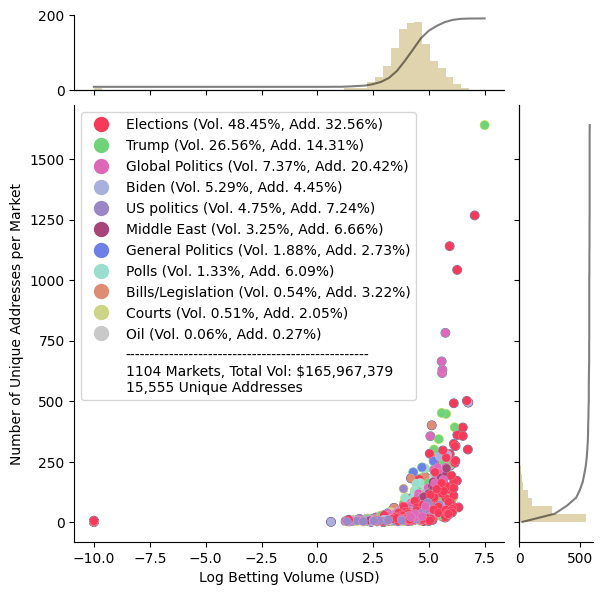

In [ ]:
x = np.log10(df_markets['volumeNum'].replace(0, 1e-10))
y = df_markets['Participants']

# Plot with joint distribution
g = sns.JointGrid(x=x, y=y)
g.ax_joint.scatter(x, y, c=pd.Categorical(df_markets['category_label']).codes, cmap='viridis')

n_bins = 50

# Plot Margins
values_x, _ = np.histogram(x, bins=n_bins)
g.ax_marg_x.hist(x, bins=n_bins, color=base_color)
max_count_x = max(values_x)

values_y, _ = np.histogram(y, bins=n_bins)
g.ax_marg_y.hist(y, bins=n_bins, orientation="horizontal", color=base_color)
max_count_y = max(values_y)

g.ax_marg_x.set_ylim(0, max_count_x * 1.1)
g.ax_marg_y.set_xlim(0, max_count_y * 1.1)

# Calculate and plot CDF of x axis
cumulative_x = np.cumsum(values_x)
ax_marg_x_cdf = g.ax_marg_x.twinx()
ax_marg_x_cdf.plot(np.linspace(x.min(), x.max(), n_bins), cumulative_x / cumulative_x[-1], c="black", alpha=0.5)
ax_marg_x_cdf.set_yticks([])
ax_marg_x_cdf.spines['top'].set_visible(False)
ax_marg_x_cdf.spines['right'].set_visible(False)

# Calculate and plot CDF of y axis
cumulative_y = np.cumsum(values_y)
ax_marg_y_cdf = g.ax_marg_y.twiny()
ax_marg_y_cdf.plot(cumulative_y / cumulative_y[-1], np.linspace(y.min(), y.max(), n_bins), c="black", alpha=0.5)
ax_marg_y_cdf.set_xticks([])
ax_marg_y_cdf.spines['top'].set_visible(False)
ax_marg_y_cdf.spines['right'].set_visible(False)


custom_category_labels = {
    'Bills & Legislation': 'Bills/Legislation',
    'Politics': 'General Politics'
}

# Add the legend
category_unique = df_markets['category_label'].unique()
category_colors = {category: (special_color if category == 'Elections' else colors[i]) for i, category in enumerate(category_counts_sorted.index)} # Highlight Elections

# By volume
legend_handles = [mlines.Line2D([], [], color=category_colors[category], marker='o', linestyle='None',
                                markersize=10, label=f"{custom_category_labels.get(category, category)} (Vol. {category_volume_percentage[category]:.2%}, Add. {category_Participants_percentage[category]:.2%})") #{category_total_Participants.get(category, 0):,.0f}")  #{category_total_volumes[category]:,.0f} Volumenum
                  for category in category_volume_percentage.index]
legend_handles.append(mpatches.Patch(color='none', label=f"{'-'*50}\n{len(df_markets)} Markets, Total Vol: ${total_volume:,.0f}\n{total_Participants_unique:,.0f} Unique Addresses"))

g.ax_joint.scatter(x, y, c=[category_colors[cat] for cat in df_markets['category_label']], s=40, edgecolor='white', linewidth=0.1)


g.ax_joint.legend(handles=legend_handles, bbox_to_anchor=(0, 1), loc='upper left')

g.set_axis_labels('Log Betting Volume (USD)', 'Number of Unique Addresses per Market')
plt.show()

# Save fig
g.fig.savefig('./figure/Event_Market_Dynamics_2.pdf', format='pdf', bbox_inches='tight')

# Predictive Accuracy of Political Markets

Outcomes that need to be supplemented are obtained through Octopus: outcome.otd

The supplemented outcome is "outcome.csv"

Focusing on "closed" market

In [ ]:
temp = pd.read_csv('./data/outcome.csv')

# cleaning and preprocess
temp['slug'] = temp['slug'].apply(lambda x: x.split('?tid=')[0])

temp['Outcome'] = temp['Outcome'].str.replace('Outcome: ', '')
temp['Outcome'] = temp['Outcome'].replace({'Yes': 1, 'No': 0})

merged_df = df_markets.merge(temp[['slug', 'Outcome']], on='slug', how='left')

merged_df = merged_df.reset_index(drop=True)
df_markets = df_markets.reset_index(drop=True)

# Update actual price
for i in merged_df.index:
    if pd.notna(merged_df.at[i, 'Outcome']):
        df_markets.at[i, 'actualprice'] = merged_df.at[i, 'Outcome']

In [ ]:
# Calculate Brier Score, focusing on closed market
closed_markets = df_markets[df_markets['closed'] == True]

closed_markets['actualprice'] = closed_markets['actualprice'].replace('1000000000000000000', 1)
closed_markets['actualprice'] = closed_markets['actualprice'].replace('-57896044618658097711785492504343953926634992332820282019728792003956564819968', 0)

closed_markets = closed_markets.reset_index(drop=True)

def determine_actualprice(row):
    if row['actualprice'] in [0, 1]:
        return row['actualprice']
    elif row['actualprice'] == row['outcome1']:
        return 1
    elif row['actualprice'] == row['outcome2']:
        return 0
    else:
        return 1 if row['outcomePrices1'] > row['outcomePrices2'] else 0

closed_markets['actualprice'] = closed_markets.apply(determine_actualprice, axis=1)

closed_markets['outcomePrices1'] = pd.to_numeric(closed_markets['outcomePrices1'], errors='coerce')
closed_markets['outcomePrices2'] = pd.to_numeric(closed_markets['outcomePrices2'], errors='coerce')
closed_markets['actualprice'] = pd.to_numeric(closed_markets['actualprice'], errors='coerce')

In [ ]:
# Calculate Brier Score and Discrete Log Score, focusing on closed market
closed_markets['Brier_Score'] = np.where(
    closed_markets['actualprice'] == 1,
    (1-closed_markets['outcomePrices1']) ** 2,
    (1-closed_markets['outcomePrices2']) ** 2
)

epsilon = 1e-6
closed_markets['outcomePrices1'] = closed_markets['outcomePrices1'].clip(lower=epsilon, upper=1-epsilon)
closed_markets['outcomePrices2'] = closed_markets['outcomePrices2'].clip(lower=epsilon, upper=1-epsilon)
closed_markets['Log_Score'] = np.where(
    closed_markets['actualprice'] == 1,
    np.log2(closed_markets['outcomePrices1']) + 1,
    np.log2(closed_markets['outcomePrices2']) + 1
)

# Average Brier Score and Discrete Log Score
average_brier_score = closed_markets['Brier_Score'].mean()
print("Average Brier Score:", average_brier_score)

average_log_score = closed_markets['Log_Score'].mean()
print("Average Discrete Log Score:", average_log_score)

Average Brier Score: 0.014511713420663434
Average Discrete Log Score: 0.7401764566912518


In [ ]:
# Sort markets by date
closed_markets_sorted = closed_markets
closed_markets_sorted['createDate'] = pd.to_datetime(closed_markets_sorted['createDate'])
closed_markets_sorted = closed_markets_sorted.sort_values(by='createDate')

# 4 months to 1 period
closed_markets_sorted['Period'] = (closed_markets_sorted['createDate'] + MonthEnd(0)).dt.to_period('4M')

# EWMA Trend
EWMA_log_Overall = closed_markets_sorted['Log_Score'].ewm(span=20).mean()

# Volume Normalized EWMA Trend
max_volume = closed_markets_sorted['volumeNum'].max()
normalized_weights_volume = closed_markets_sorted['volumeNum'] / max_volume
normalized_volume_EWMA = EWMA_log_Overall * normalized_weights_volume

# Participants Normalized EWMA Trend
max_participants = closed_markets_sorted['Participants'].max()
normalized_weights_participants = closed_markets_sorted['Participants'] / max_participants
normalized_participants_EWMA = EWMA_log_Overall * normalized_weights_participants 

In [ ]:
# Evaluate the influence
closed_markets_sorted['normalized_volume'] = normalized_volume_EWMA
closed_markets_sorted['normalized_participants'] = normalized_participants_EWMA
closed_markets_sorted['EWMA_log_Overall'] = EWMA_log_Overall
closed_markets_sorted = closed_markets_sorted.dropna(subset=['normalized_volume', 'normalized_participants'])

X = closed_markets_sorted[['normalized_volume', 'normalized_participants']]
y = closed_markets_sorted['EWMA_log_Overall']

model = LinearRegression().fit(X, y)

print('Coefficients:', model.coef_)

print('R^2 score:', model.score(X, y))

Coefficients: [-5.18486288  5.54864835]
R^2 score: 0.5503134279509954


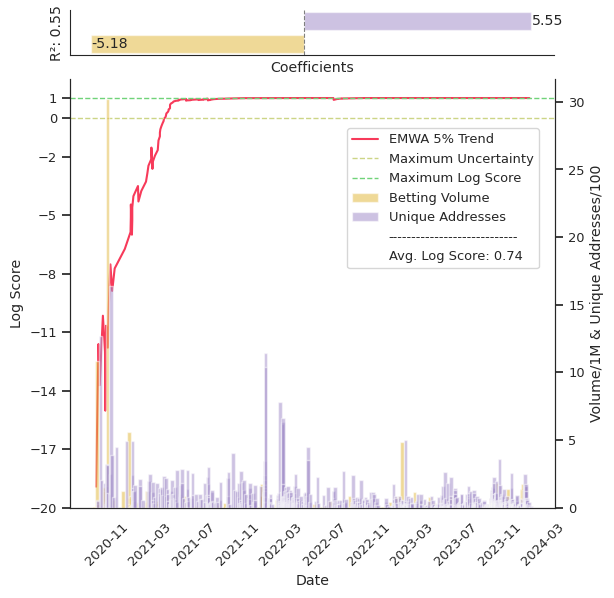

In [ ]:
# Set style
sns.set(style='white', font_scale=0.85)
fig, ax1 = plt.subplots(figsize=(6.25, 5.4))

# Plot score line
ax1.plot(closed_markets_sorted['createDate'], EWMA_log_Overall, label='EMWA 5% Trend', color=special_color)

# Plot maximum uncertainty score line and maximum log score line
ax1.axhline(0, color=colors[7], linestyle='--', linewidth=1, label='Maximum Uncertainty')
ax1.axhline(1, color=colors[3], linestyle='--', linewidth=1, label='Maximum Log Score')

# Main axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Score')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.xticks(rotation=45)
min_tick = min(ax1.get_yticks())
max_tick = 1.5
ticks = np.arange(min_tick, max_tick, 3)
ticks = sorted(set(ticks.tolist() + [0]))
ax1.set_yticks(ticks)

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_linewidth(0.8)
ax1.spines['left'].set_linewidth(0.8)
ax1.spines['right'].set_linewidth(0.8)

# second axis
width = 10  # bar chart width
ax2 = ax1.twinx()
ax2.bar(closed_markets_sorted['createDate'] - pd.Timedelta(days=width/2), closed_markets_sorted['volumeNum']/1000000, \
        width=width, label='Betting Volume', color=colors[0], alpha=0.5) #alpha=0.4
ax2.bar(closed_markets_sorted['createDate'] + pd.Timedelta(days=width/2), closed_markets_sorted['Participants']/100, \
        width=width, label='Unique Addresses', color=colors[2], alpha=0.5)
ax2.set_ylabel('Volume/1M & Unique Addresses/100')

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_linewidth(0.8)
ax2.spines['left'].set_linewidth(0.8)
ax2.spines['right'].set_linewidth(0.8)

# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
separator_line = Line2D([0], [0], color="white", linestyle="--")
separator_legend = ["-" * 28, "Avg. Log Score: {:.2f}".format(average_log_score)]

all_lines = lines + lines2 + [separator_line, separator_line]
all_labels = labels + labels2 + separator_legend
ax1.legend(all_lines, all_labels, loc='upper right', bbox_to_anchor=(0.98, 0.9))

# Margin plot
axins = inset_axes(ax1, width="100%", height="30%", loc='lower left',
                   bbox_to_anchor=(-0.015,1.04,1,0.35), bbox_transform=ax1.transAxes) 

#Add model coefficients and R^2 score
coefficients = [model.coef_[0], model.coef_[1]]
r2_score = model.score(X, y)
variables = ['Volume', 'Address']
colors_margin = [colors[0], colors[2]]

bars = axins.barh(variables, coefficients, color=colors_margin, alpha=0.5) 
for bar, coeff in zip(bars, coefficients):
    axins.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
               f'{coeff:.2f}', va='center')

axins.set_xlabel('Coefficients')
axins.set_xticks([])
axins.set_ylabel(f'R²: {r2_score:.2f}')
axins.set_yticks([])
axins.set_xlim([min(coefficients + [0])* 1.1, max(coefficients) * 1.1])  
axins.axvline(0, color='grey', linewidth=0.8, linestyle='--')  


axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.spines['left'].set_linewidth(0.8)
axins.spines['bottom'].set_linewidth(0.8)


plt.tight_layout()

# Save the fig
plt.savefig('./figure/Event_Market_Dynamics_3.pdf', format='pdf', bbox_inches='tight')

plt.show()

# Comparing Political Participants with the General

In [ ]:
import json
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import cumfreq
from scipy.stats import beta
from datetime import datetime
from sklearn.linear_model import LinearRegression

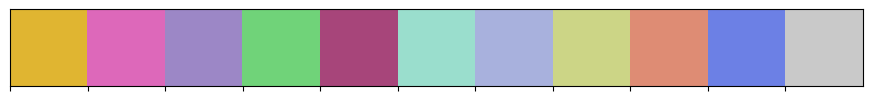

In [ ]:
special_color = "#F73A5A"
base_color = '#E0D4AE'
colors = ["#E0B531", "#DD68BA", "#9C87C6", "#70D379", "#A7457A", "#9ADECD", "#A8B1DD", "#CCD586", "#DE8C74", "#6C80E5", "#C9C9C9"]

sns.palplot(colors)

In [ ]:
with open('./data/politics_users_profile_api.json', 'r', encoding='utf-8') as file:
    politics_users_profile = json.load(file)
with open('./data/markets_user_data_all.json', 'r', encoding='utf-8') as file:
    all_users_overview = json.load(file)

In [ ]:
# Transforming data into DataFrame
df_data = pd.DataFrame({
    "createdAt": [profile["profile"]["createdAt"] for profile in politics_users_profile.values()],
    "totalProfit": [profile["profit"]["total"] for profile in politics_users_profile.values()],
    "marketsTraded": [profile["marketsTraded"] for profile in politics_users_profile.values()],
    "volumeTraded": [profile["volumeTraded"] for profile in politics_users_profile.values()],
    "activityNum": [profile["activityNum"] for profile in politics_users_profile.values()],
})
df_data["createdAt"] = pd.to_datetime(df_data["createdAt"])
df_data["year"] = df_data["createdAt"].dt.year
df_data["year"] = df_data["year"].astype("Int64")

df_all_users = pd.DataFrame(all_users_overview)
df_all_users["creationTimestamp"] = pd.to_datetime(df_all_users["creationTimestamp"].astype(int), unit='s')
df_all_users["year"] = df_all_users["creationTimestamp"].dt.year
df_all_users["scaledProfit"] = df_all_users["scaledProfit"].astype(float)
df_all_users["numTrades"] = df_all_users["numTrades"].astype(int)
df_all_users["scaledCollateralVolume"] = df_all_users["scaledCollateralVolume"].astype(float)

## Creation year distribution

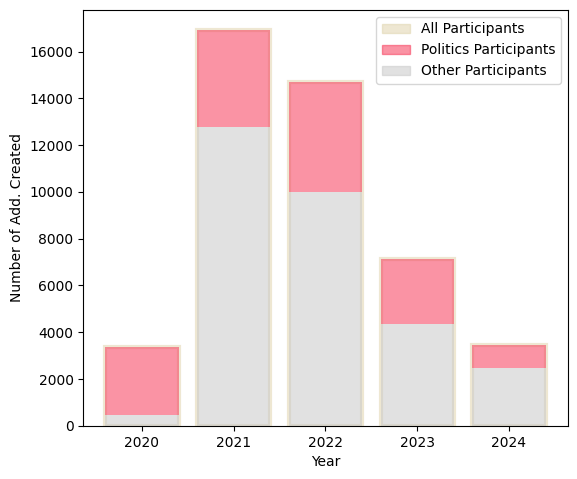

In [ ]:
plt.figure(figsize=(6.25, 5.4))

all_users_yearly = df_all_users["year"].value_counts().sort_index()
politics_users_yearly = df_data["year"].value_counts().sort_index()

years = sorted(set(all_users_yearly.index) | set(politics_users_yearly.index))

# Calculate add. created in each year
all_users_counts = [all_users_yearly.get(year, 0) for year in years]
politics_users_counts = [politics_users_yearly.get(year, 0) for year in years]
non_politics_users_counts = [all_users - politics for all_users, politics in zip(all_users_counts, politics_users_counts)]

# all
plt.bar(years, all_users_counts, color='none', edgecolor=base_color, linewidth=3, label='All Participants', alpha=0.55)
plt.bar(years, politics_users_counts, bottom=non_politics_users_counts, color=special_color, label='Politics Participants', alpha=0.55)
plt.bar(years, non_politics_users_counts, color=colors[-1], label='Other Participants', alpha=0.55)

# Legend
all_participants_patch = mpatches.Patch(color=base_color, label='All Participants', alpha=0.55)

plt.legend(handles=[
    all_participants_patch,
    mpatches.Patch(color=special_color, label='Politics Participants', alpha=0.55),
    mpatches.Patch(color=colors[-1], label='Other Participants', alpha=0.55)
])

plt.xticks(years, [str(year) for year in years])
plt.xlabel('Year')
plt.ylabel('Number of Add. Created')
# plt.legend()

# Save the fig
plt.savefig('./figure/Address_Dynamics_1.pdf', format='pdf', bbox_inches='tight')

plt.show()

## P/L Distribution

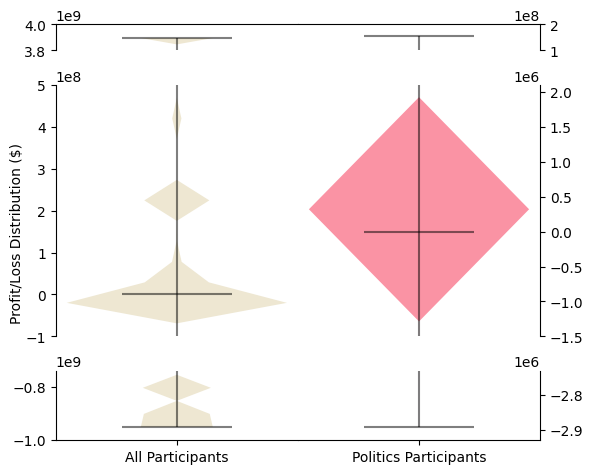

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(6.25, 5.4), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [0.3, 2.9, 0.8]})
fig.subplots_adjust(hspace=0.3, wspace=0)

# Left
for ax in axes[:, 0]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.yaxis.tick_left()

axes[0, 0].set_ylim(3.8e9, 4e9)  # Top left
axes[1, 0].set_ylim(-0.1e9, 0.5e9)  # Middle left
axes[2, 0].set_ylim(-1e9, -0.74e9)  # Bottom left

#Right
for ax in axes[:, 1]:
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

axes[0, 1].set_ylim(1e8, 2e8)  # Top right
axes[1, 1].set_ylim(-1.5e6, 2.1e6)  # Middle right
axes[2, 1].set_ylim(-2.93e6, -2.73e6)  # Bottom right

for i in range(3):  # all Participants
    parts_all = axes[i, 0].violinplot(df_all_users['scaledProfit'], showmeans=False, showmedians=True)
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = parts_all[partname]
        vp.set_edgecolor('black')
        vp.set_alpha(0.5)
        vp.set_linewidth(1.5)
    for pc in parts_all['bodies']:
        pc.set_facecolor(base_color)
        #pc.set_edgecolor('black')
        pc.set_alpha(.55)

for i in range(3):  # Politics
    parts_pol = axes[i, 1].violinplot(df_data['totalProfit'], showmeans=False, showmedians=True)
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = parts_pol[partname]
        vp.set_edgecolor('black')
        vp.set_alpha(0.5)
        vp.set_linewidth(1.5)
    for pc in parts_pol['bodies']:
        pc.set_facecolor(special_color)
        #pc.set_edgecolor('black')
        pc.set_alpha(.55)


# Set X
axes[2, 0].spines['bottom'].set_visible(True)
axes[2, 1].spines['bottom'].set_visible(True)
axes[0, 0].spines['top'].set_visible(True)
axes[0, 1].spines['top'].set_visible(True)

axes[2, 0].set_xticks([1])
axes[2, 0].set_xticklabels(['All Participants'])
axes[2, 1].set_xticks([1])
axes[2, 1].set_xticklabels(['Politics Participants'])

# Adding the unified Y label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Profit/Loss Distribution ($)', labelpad=0)

# Save the fig
plt.savefig('./figure/Address_Dynamics_2.pdf', format='pdf', bbox_inches='tight')

plt.show()

## Log Distribution of Markets Traded

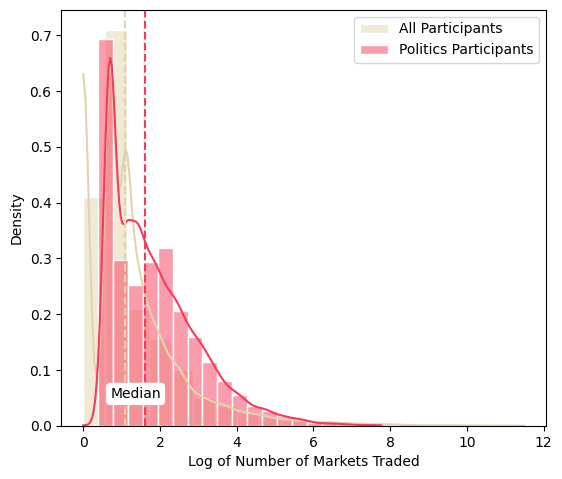

In [ ]:
plt.figure(figsize=(6.25, 5.4))

# Log
df_all_users['log_numTrades'] = np.log1p(df_all_users['numTrades'])
df_data['log_marketsTraded'] = np.log1p(df_data['marketsTraded'])

# Bin setting
bin_number = 20
bin_edge_color = 'white'
bin_line_width = 1

# KDE line setting
kde_linewidth = 2
kde_style = ':'

sns.histplot(df_all_users['log_numTrades'], bins=bin_number, kde=True, color=base_color, edgecolor=bin_edge_color, linewidth=bin_line_width, label='All Participants',stat="density", common_norm=False)
sns.histplot(df_data['log_marketsTraded'], bins=bin_number, kde=True, color=special_color, edgecolor=bin_edge_color, linewidth=bin_line_width, label='Politics Participants', stat="density", common_norm=False)


plt.axvline(x=df_data['log_marketsTraded'].median(), color=special_color, linestyle='--')
plt.axvline(x=df_all_users['log_numTrades'].median(), color=base_color, linestyle='--')
plt.annotate('Median',
             xy=(df_data['log_marketsTraded'].median(), 0),
             xytext=(-25, 20),
             textcoords='offset points',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0))

plt.xlabel('Log of Number of Markets Traded')
plt.ylabel('Density')
plt.legend() 
plt.savefig('./Address_Dynamics_3.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Distribution of Volume Traded

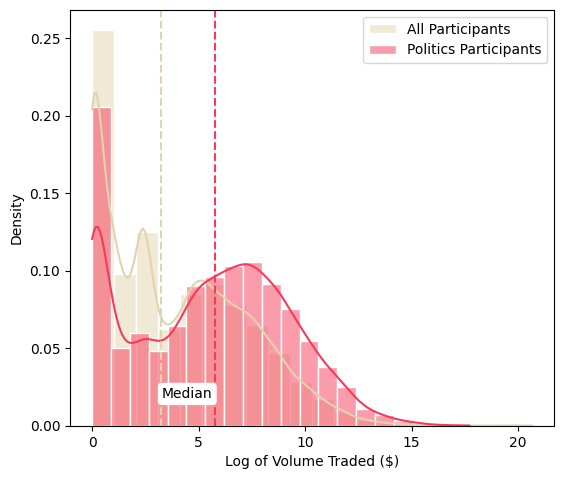

In [ ]:
plt.figure(figsize=(6.25, 5.4))

# Log
df_all_users['log_scaledCollateralVolume'] = np.log1p(df_all_users['scaledCollateralVolume'])
df_data['log_volumeTraded'] = np.log1p(df_data['volumeTraded'])

# Bin setting
bin_number = 20
bin_edge_color = 'white'
bin_line_width = 1

sns.histplot(df_all_users['log_scaledCollateralVolume'], color=base_color, bins=bin_number, edgecolor=bin_edge_color, linewidth=bin_line_width, label='All Participants', kde=True, stat="density", common_norm=False)
sns.histplot(df_data['log_volumeTraded'], color=special_color, bins=bin_number, edgecolor=bin_edge_color, linewidth=bin_line_width, label='Politics Participants', kde=True, stat="density", common_norm=False)

plt.axvline(x=df_data['log_volumeTraded'].median(), color=special_color, linestyle='--')
plt.axvline(x=df_all_users['log_scaledCollateralVolume'].median(), color=base_color, linestyle='--')
plt.annotate('Median',
             xy=(df_data['log_volumeTraded'].median(), 0),
             xytext=(-38, 20),
             textcoords='offset points',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0))


plt.xlabel('Log of Volume Traded ($)')
plt.ylabel('Density')
plt.legend()
plt.savefig('./figure/Address_Dynamics_4.pdf', format='pdf', bbox_inches='tight')
plt.show()